In [2]:
%pip install pyberny

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install qiskit==1.4.2
%pip install qiskit-nature
%pip install qiskit-ibm-runtime
%pip install pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.3 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 33.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 15.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.8/366.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use

Starting optimization for CO2...


/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '
/usr/local/lib/python3.11/dist-packages/berny/Math.py:19: RuntimeWarning: divide by zero encountered in divide
  gaps = D[:-1] / D[1:]


Optimization for CO2 finished.
Starting optimization for NH3...
Optimization for NH3 finished.
Starting optimization for NH2COOH...
Optimization for NH2COOH finished.

Optimized XYZ geometries saved to ./xyz/
Running for N-C distance = 1.50 Å ...
Running for N-C distance = 1.86 Å ...
Running for N-C distance = 2.21 Å ...
Running for N-C distance = 2.57 Å ...
Running for N-C distance = 2.93 Å ...
Running for N-C distance = 3.29 Å ...
Running for N-C distance = 3.64 Å ...
Running for N-C distance = 4.00 Å ...


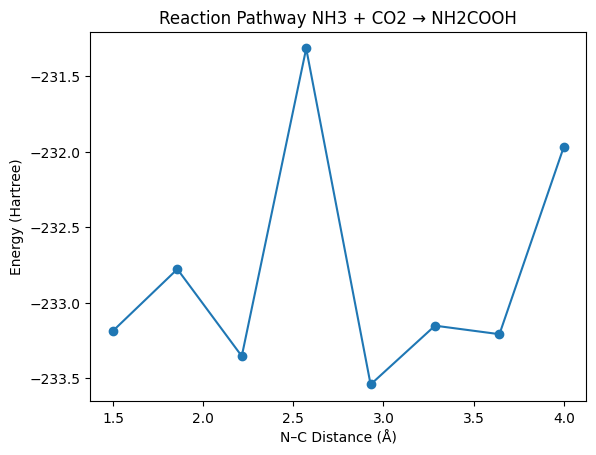

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pyscf import gto, dft
from pyscf.geomopt import berny_solver as geomopt
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import StatevectorEstimator
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

# ==========================
# PySCF Geometry Optimization
# ==========================

CO2_start = '''
C  0.000000  0.000000  0.000000
O  0.000000  0.000000  1.160000
O  0.000000  0.000000 -1.160000
'''

NH3_start = '''
N  0.000000  0.000000  0.000000
H  0.000000  0.935000  0.381000
H  0.809000 -0.467000  0.381000
H -0.809000 -0.467000  0.381000
'''

NH2COOH_start = '''
C  0.000000  0.000000  0.000000
O  1.200000  0.000000  0.000000
O -1.200000  0.000000  0.000000
N  0.000000  1.400000  0.000000
H  0.000000  2.100000  0.800000
H  0.000000  2.100000 -0.800000
H  0.000000 -0.600000  0.900000
'''

def run_pyscf_opt(xyz_string, name, method='b3lyp', basis='cc-pvtz', maxiter=50):
    print(f"Starting optimization for {name}...")

    atom_lines = [l for l in xyz_string.strip().splitlines() if l.strip()]
    atom_spec = '; '.join([' '.join(l.split()) for l in atom_lines])

    mol = gto.M(atom=atom_spec, basis=basis, unit='Angstrom', verbose=0)
    mf = dft.RKS(mol)
    mf.xc = method

    mol_opt = geomopt.optimize(mf, maxsteps=maxiter)

    coords = mol_opt.atom_coords()
    symbols = [mol_opt.atom_symbol(i) for i in range(mol_opt.natm)]
    xyz_lines = [f"{s} {c[0]:.8f} {c[1]:.8f} {c[2]:.8f}" for s, c in zip(symbols, coords)]
    xyz_out = '\n'.join(xyz_lines) + '\n'

    print(f"Optimization for {name} finished.")
    return xyz_out

# Create output directory
os.makedirs('xyz', exist_ok=True)

# Run optimizations
co2_xyz = run_pyscf_opt(CO2_start, 'CO2')
nh3_xyz = run_pyscf_opt(NH3_start, 'NH3')
nh2cooh_xyz = run_pyscf_opt(NH2COOH_start, 'NH2COOH')

# Save to XYZ files
with open('xyz/CO2_opt.xyz','w') as f: f.write(co2_xyz)
with open('xyz/NH3_opt.xyz','w') as f: f.write(nh3_xyz)
with open('xyz/NH2COOH_opt.xyz','w') as f: f.write(nh2cooh_xyz)

print("\nOptimized XYZ geometries saved to ./xyz/")

# =====================================
# Qiskit Energy Calculations Using Optimized Geometries
# =====================================

# Convert optimized XYZ strings to PySCF-compatible format
def xyz_to_pyscf_string(xyz_string):
    atom_lines = [l for l in xyz_string.strip().splitlines() if l.strip()]
    return '; '.join([' '.join(l.split()) for l in atom_lines])

# N-C distance scan using optimized NH3 and CO2
def make_geometry(n_c_distance, nh3_xyz=nh3_xyz, co2_xyz=co2_xyz):
    # Extract coordinates from optimized geometries
    nh3_atoms = [line.split() for line in nh3_xyz.strip().splitlines()]
    co2_atoms = [line.split() for line in co2_xyz.strip().splitlines()]

    # Shift CO2 C atom to desired N-C distance
    n_coord = np.array([float(x) for x in nh3_atoms[0][1:]])
    c_coord = np.array([float(x) for x in co2_atoms[0][1:]])
    shift = n_c_distance - np.linalg.norm(c_coord - n_coord)
    co2_shifted = []
    for atom in co2_atoms:
        coord = np.array([float(x) for x in atom[1:]])
        coord[0] += shift  # move along x-axis
        co2_shifted.append((atom[0], coord.tolist()))

    # Build final geometry string
    geometry = [(atom[0], [float(x) for x in atom[1:]]) for atom in nh3_atoms] + co2_shifted
    return "; ".join([f"{atom} {x} {y} {z}" for atom, (x, y, z) in geometry])

def compute_energy(geometry_str):
    driver = PySCFDriver(atom=geometry_str, basis="sto-3g", charge=0, spin=0)
    es_problem = driver.run()

    transformer = ActiveSpaceTransformer(num_electrons=6, num_spatial_orbitals=6)
    es_problem = transformer.transform(es_problem)

    mapper = JordanWignerMapper()
    uccsd_ansatz = UCCSD(
        num_spatial_orbitals=es_problem.num_spatial_orbitals,
        num_particles=es_problem.num_particles,
        qubit_mapper=mapper,
    )

    optimizer = SLSQP(maxiter=50)
    vqe = VQE(StatevectorEstimator(), ansatz=uccsd_ansatz, optimizer=optimizer)

    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(es_problem)

    return result.total_energies[0].real

# Scan N-C distance
distances = np.linspace(1.5, 4.0, 8)
energies = []

for d in distances:
    geom_str = make_geometry(d)
    print(f"Running for N-C distance = {d:.2f} Å ...")
    energy = compute_energy(geom_str)
    energies.append(energy)

# Plot Reaction Pathway
plt.plot(distances, energies, marker="o")
plt.xlabel("N–C Distance (Å)")
plt.ylabel("Energy (Hartree)")
plt.title("Reaction Pathway NH3 + CO2 → NH2COOH")
plt.show()
